In [9]:

import scipy.linalg as la
from scipy.optimize import minimize
from pylab import *
from qutip import *
import scqubits as scq
import matplotlib
matplotlib.rcParams['font.family'] = "Arial"
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams.update({'font.size': 22})
import matplotlib.pyplot as plt
import time 
from numpy.linalg import inv
import timeit
import numpy as np
pi = np.pi
import numpy.matlib

# Default constant and simulation coeff

In [10]:
## Default constant
eq = 1.602/10**19
epsilon = 8.854/10**12
h = 6.636/10**34
hbar = h/2/pi
kb = 1.381/10**23
Tc = 1.2
delta = 1.764*kb*Tc
phi0 = h/2/eq
dielectric = 9.34*epsilon

In [11]:
## Coefficient used in experiment
HFSSratio = 0.95
Rratio = 0.9
# 'Experience' constant
thickness = 1.4/10**9
# resistance vs. capacitance
r_standard = 16000
width = 165/10**9
length = 155/10**9

# Three node VSTA10-V quantization simulation

In [12]:
def Vstar_sc_3node(circuitparam, printout=False):
    Ej1 = circuitparam['Ej1']
    Ej2 = circuitparam['Ej2']
    Ejc1 = circuitparam['Ejc1']
    Ejc2 = circuitparam['Ejc2']
    CL = circuitparam['CL']
    invC = circuitparam['invC']
    Phidc = circuitparam['Phidc']
    
    
    ###############################
    
    Ejs = Ejc1+Ejc2
    d = (Ejc1-Ejc2)/(Ejc1+Ejc2)
    Ejg = abs(Ejs*sqrt(cos(Phidc)**2+d**2*sin(Phidc)**2))

    Zq1 = sqrt(8*invC[0,0]/Ej1)
    Zq2 = sqrt(8*invC[1,1]/Ej2)
    Zqg = sqrt(8*invC[2,2]/Ejg)

    invC1 = inv(CL*10**15)
    Hn = invC1*2*eq**2/h/10**9*10**15
    lista = np.array([1/sqrt(Zq1), 1/sqrt(Zq2), 1/sqrt(Zqg)])
    Cquantized = np.multiply(np.outer(lista,lista),Hn)
#     print(Cquantized)


    # setting up Q1 (tmon1), Q2 (tmon2), Qc (tmonc) Hilbert space
    tmon1 = scq.Transmon(
        EJ=Ej1,
        EC=invC[0,0],
        ng=0.0,
        ncut=Qubit_cut,
        truncated_dim=Truncate_dim     # after diagonalization, we will keep 4 levels
    )
#     print(dir(tmon1))

    tmon2 = scq.Transmon(
        EJ=Ej2,
        EC=invC[1,1],
        ng=0.0,
        ncut=Qubit_cut,
        truncated_dim=Truncate_dim
    )

    tmon3 = scq.Transmon(
        EJ=Ejg,
        EC=invC[2,2],
        ng=0.0,
        ncut=Qubit_cut,
        truncated_dim=Truncate_dim
    )

    hilbertspace = scq.HilbertSpace([tmon1, tmon2, tmon3])

    g1 = Ej1  # coupling resonator-tmon1 (without charge matrix elements)
    g2 = Ej2
    g12 = Cquantized[0,1]
    g1c = Cquantized[0,2]
    g2c = Cquantized[1,2]

#     print(Cquantized)
    n1 = tmon1.n_operator()
    n2 = tmon2.n_operator()
    n3 = tmon3.n_operator()

    p1 = tmon1.exp_i_phi_operator()
    p2 = tmon2.exp_i_phi_operator()
    p3 = tmon3.exp_i_phi_operator()
    p1c = tmon1.cos_phi_operator()
    p2c = tmon2.cos_phi_operator()
#     print(g1g)
#     print(g12)
    
    hilbertspace.add_interaction(
        g=g1,
        op1=(p1c, tmon1),
    add_hc=False
    )
    hilbertspace.add_interaction(
        g=g2,
        op1=(p2c, tmon2),
    add_hc=False
    )

    hilbertspace.add_interaction(
        g=-g1/2,
        op1=(p1, tmon1),
        op2=(p3.T, tmon3),
    add_hc=True
    )
    hilbertspace.add_interaction(
        g=-g2/2,
        op1=(p2, tmon2),
        op2=(p3.T, tmon3),
    add_hc=True
    )

    hilbertspace.add_interaction(
        g=g12,
        op1=(n1, tmon1),
        op2=(n2, tmon2),
    add_hc=False
    )
    hilbertspace.add_interaction(
        g=g1c,
        op1=(n1, tmon1),
        op2=(n3, tmon3),
    add_hc=False
    )
    hilbertspace.add_interaction(
        g=g2c,
        op1=(n2, tmon2),
        op2=(n3, tmon3),
    add_hc=False
    )

    dressed_hamiltonian = hilbertspace.hamiltonian()
    result = dressed_hamiltonian.eigenstates()
    energy = result[0]
    state = result[1]
    # sequence Q, Q, C
    #  reordering the eigenvalues
    order = Truncate_dim
    orderc = Truncate_dim
    max_list = []
    maxlist = np.zeros([order,order,orderc])
    for i in range(len(state)):
        aaa = abs(np.array(state[i]))
        name = np.argmax(aaa)
        k1 = name // (order*orderc)
        k2 = (name - k1 * (order*orderc))//(orderc)
        k3 = (name-k1 * (order*orderc)-k2*orderc)
        now = state[i].dag()*dressed_hamiltonian*state[i]
        maxlist[k1][k2][k3] = np.array(now)[0][0]
    maxlist = maxlist-energy[0]
        
    # calculate all information
    Q1 = maxlist[1][0][0] - maxlist[0][0][0]
    Q2 = maxlist[0][1][0] - maxlist[0][0][0]
    Qc = maxlist[0][0][1] - maxlist[0][0][0]
    ZZ = maxlist[1][1][0] - maxlist[1][0][0] - maxlist[0][1][0] + maxlist[0][0][0]
    ZZef = maxlist[2][2][0] - maxlist[1][2][0] - maxlist[2][0][0] + maxlist[1][0][0]
    ZZfe = maxlist[2][2][0] - maxlist[2][1][0] - maxlist[0][2][0] + maxlist[0][1][0]
    Q1_a = maxlist[2][0][0] - 2*maxlist[1][0][0] + maxlist[0][0][0]
    Q2_a = maxlist[0][2][0] - 2*maxlist[0][1][0]+ maxlist[0][0][0]
    Q3_a = maxlist[0][0][2]- 2*maxlist[0][0][1] + maxlist[0][0][0]
    
    if printout:

        print('Q1: ',Q1)
        print('Q2: ',Q2)
        print('Qc: ',Qc)
        print('ZZ: ',ZZ)
        print('ZZ_ff1: ',ZZef)
        print('ZZ_ff2: ',ZZfe)

        print('Q1_a: ',Q1_a)
        print('Q2_a: ',Q2_a)
        print('Q3_a: ',Q3_a)

    return maxlist

In [14]:
# def minzz(ZZlist):
#     Jlist = []
# #     print(ZZlist)
#     def fun(x, *args):
#         return abs(x[0] - ZZlist[0]) + abs(x[1] - ZZlist[1]) + abs(x[2] - ZZlist[2]) + abs(x[2]-x[0]-ZZlist[3]) +\
#                         abs(x[1]-x[0]-ZZlist[4]) + abs(x[3]-x[1]-ZZlist[5]) + abs(x[3]-x[2]-ZZlist[6])
#     args={'ZZlist':ZZlist}
#     x0 = [-0.0001,-0.0005,-0.0002,-0.0008]
# #     x0 = guess
#     res = minimize(fun, x0, args=args, method='Powell',options={'xtol':1E-10,'ftol':1E-10})
#     x1 = np.array(res.x)
#     VV = np.matrix([[1,0,0,0],[2,2,0,0],[2,0,2,0],[4,4,4,4]])
#     Jlist = np.matmul(inv(VV),x1)*1000*1000
#     return Jlist

def minzz(ZZlist):
    Jlist = []
#     print(ZZlist)
    def fun(x, *args):
        return (x[0] - ZZlist[0])**2 + (x[1] - ZZlist[1])**2 + (x[2] - ZZlist[2])**2 + (x[2]-x[0]-ZZlist[3])**2 +\
                        (x[1]-x[0]-ZZlist[4])**2 + (x[3]-x[1]-ZZlist[5])**2 + (x[3]-x[2]-ZZlist[6])**2
    args={'ZZlist':ZZlist}
    x0 = [-0.0001,-0.0005,-0.0002,-0.0008]
#     x0 = guess
    res = minimize(fun, x0, args=args, method='Powell',options={'xtol':1E-10,'ftol':1E-10})
    x1 = np.array(res.x)
    VV = np.matrix([[1,1,1,1],[2,4,2,4],[2,2,4,4],[4,8,8,16]])
    Jlist = np.matmul(inv(VV),x1)*1000*1000
    return Jlist

In [15]:
minzz([-0.00010831904989316854,-0.0005366797738934892,-0.00022438017368164864,-0.00011635118896391461,-0.0004305727512345925,-0.00024116092890480445,-0.0005594313188108657])

matrix([[ 135.62664806, -239.32496361,  -81.85970488,   77.86449353]])

In [16]:
Phidc = 0.0 * pi
# quantization main part
Qubit_cut = 25
Truncate_dim = 6
## HFSS simulation and room temperature resistance
CQ1 = 178/10**15*HFSSratio
CQ2 = 131/10**15*HFSSratio
CQ12 = (2.0-0.0)/10**15*HFSSratio

Rj1 = 12945 * Rratio * 0.898
Rj2 = 13212 * Rratio * 0.886
Rjc1 = (277-0) * Rratio
Rjc2 = (278-0) * Rratio

Cj1 = (dielectric*length*width)/thickness*r_standard/Rj1*0
Cj2 = (dielectric*length*width)/thickness*r_standard/Rj2*0
Cjc1 = (dielectric*length*width)/thickness*r_standard/Rjc1
Cjc2 = (dielectric*length*width)/thickness*r_standard/Rjc2
Cg = Cjc1 + Cjc2

CL = np.matrix([[CQ1+CQ12+Cj1, -CQ12,        -Cj1       ],
                [-CQ12,        CQ2+CQ12+Cj2, -Cj2       ],
                [-Cj1,         -Cj2,         Cg+Cj1+Cj2 ]])
invC = inv(CL)*eq**2/2/h/10**9
# Lc = 1/4/pi/pi/freq_c/freq_c/CC/10**18

Ej1 = h/8*delta/eq**2/Rj1/h/10**9
Ej2 = h/8*delta/eq**2/Rj2/h/10**9
Ejc1 = h/8*delta/eq**2/Rjc1/h/10**9
Ejc2 = h/8*delta/eq**2/Rjc2/h/10**9
circuitparam = {}
circuitparam['invC'] = invC
circuitparam['CL'] = CL
circuitparam['Ej1'] = Ej1
circuitparam['Ej2'] = Ej2
circuitparam['Ejc1'] = Ejc1
circuitparam['Ejc2'] = Ejc2
circuitparam['Phidc'] = Phidc
maxlist = Vstar_sc_3node(circuitparam, printout=True)

Q1:  3.361905739203621
Q2:  3.8765075979163157
Qc:  30.424065899271
ZZ:  -0.0012434125173967914
ZZ_ff1:  -0.0005415380785507296
ZZ_ff2:  -0.005015433114522239
Q1_a:  -0.11863992494386366
Q2_a:  -0.1627672849190276
Q3_a:  -0.0995295576335593


 C:\Users\slab\.conda\envs\Vstar\lib\site-packages\ipykernel_launcher.py: 135

In [17]:
circuitparam

{'invC': matrix([[0.11310065, 0.00170076, 0.        ],
         [0.00170076, 0.15306855, 0.        ],
         [0.        , 0.        , 0.09990075]]),
 'CL': matrix([[ 1.71000000e-13, -1.90000000e-15, -0.00000000e+00],
         [-1.90000000e-15,  1.26350000e-13, -0.00000000e+00],
         [-0.00000000e+00, -0.00000000e+00,  1.93561907e-13]]),
 'Ej1': 13.609356606358375,
 'Ej2': 13.514926824495655,
 'Ejc1': 571.1316350174716,
 'Ejc2': 569.077204675682,
 'Phidc': 0.0}

In [18]:
# sweep range
sweep_range = np.linspace(-0.04, 0.4591, 101) * pi
fQ1 = []
fQ2 = []
fQc = []
fQg = []
ZZ = []
ZZef = []
ZZfe = []
Q1_a = []
Q2_a = []
ZZgf = []
ZZfg = []
ZZff1 = []
ZZff2 = []
Jab = []
Ja2b = []
Jab2 = []
Ja2b2 = []
iterno = 0
for Phidc in sweep_range:
    ##########################################################
    if iterno%10==0:
        print('Step number: ',iterno)
    iterno+=1
    circuitparam['Phidc'] = Phidc
    maxlist = Vstar_sc_3node(circuitparam, printout=False)
    
    fQ1.append(maxlist[1][0][0] - maxlist[0][0][0])
    fQ2.append(maxlist[0][1][0] - maxlist[0][0][0])
    fQc.append(maxlist[0][0][1] - maxlist[0][0][0])
    ZZ.append(maxlist[1][1][0] - maxlist[1][0][0] - maxlist[0][1][0] + maxlist[0][0][0])
    ZZgf.append(maxlist[1][2][0] - maxlist[0][2][0] - maxlist[1][0][0] + maxlist[0][0][0])
    ZZfg.append(maxlist[2][1][0] - maxlist[2][0][0] - maxlist[0][1][0] + maxlist[0][0][0])
    ZZef.append(maxlist[2][1][0] - maxlist[1][1][0] - maxlist[2][0][0] + maxlist[1][0][0])
    ZZfe.append(maxlist[1][2][0] - maxlist[1][1][0] - maxlist[0][2][0] + maxlist[0][1][0])
    ZZff1.append(maxlist[2][2][0] - maxlist[1][2][0] - maxlist[2][0][0] + maxlist[1][0][0])
    ZZff2.append(maxlist[2][2][0] - maxlist[2][1][0] - maxlist[0][2][0] + maxlist[0][1][0])
    JJ = minzz([ZZ[-1],ZZgf[-1],ZZfg[-1],ZZef[-1],ZZfe[-1],ZZff1[-1],ZZff2[-1]])
    Jab.append(JJ[0,0])
    Ja2b.append(JJ[0,2])
    Jab2.append(JJ[0,1])
    Ja2b2.append(JJ[0,3])
    Q1_a.append(maxlist[2][0][0] - 2*maxlist[1][0][0] + maxlist[0][0][0])
    Q2_a.append(maxlist[0][2][0] - 2*maxlist[0][1][0] + maxlist[0][0][0])
    


Step number:  0


 C:\Users\slab\.conda\envs\Vstar\lib\site-packages\ipykernel_launcher.py: 135

Step number:  10
Step number:  20
Step number:  30
Step number:  40
Step number:  50
Step number:  60
Step number:  70
Step number:  80
Step number:  90
Step number:  100


In [19]:
Q1_exp = [3.3613333333333335,
 3.3566666666666665,
 3.358,
 3.3566666666666665,
 3.3553333333333333,
 3.3553333333333333,
 3.354,
 3.352,
 3.3533333333333335,
 3.3486666666666665,
 3.3466666666666667,
 3.3426666666666667,
 3.3386666666666667,
 3.328,
 3.3086666666666664]
Q2_exp = [3.877111111111111,
 3.8716666666666666,
 3.873222222222222,
 3.8716666666666666,
 3.870111111111111,
 3.870111111111111,
 3.8685555555555555,
 3.8662222222222224,
 3.8677777777777775,
 3.8623333333333334,
 3.86,
 3.8553333333333333,
 3.8506666666666667,
 3.8382222222222224,
 3.8156666666666665]

Q2ef_exp = [3.748,
 3.748,
 3.747,
 3.747,
 3.747,
 3.747,
 3.747,
 3.747,
 3.745,
 3.738,
 3.733,
 3.73,
 3.722,
 3.712,
 3.702]
Q2ef_exp=np.array(Q2_exp)-0.16023
Q1ef_exp=np.array(Q1_exp)-0.115

current_exp = np.array([-3.        , -2.93333333, -2.86666667, -2.8       , -2.73333333,
       -2.66666667, -2.6       , -2.53333333, -2.46666667, -2.4       ,
       -2.33333333, -2.26666667, -2.2       , -2.13333333, -2.06666667])
current_exp = (current_exp+3)/1.87-0.04

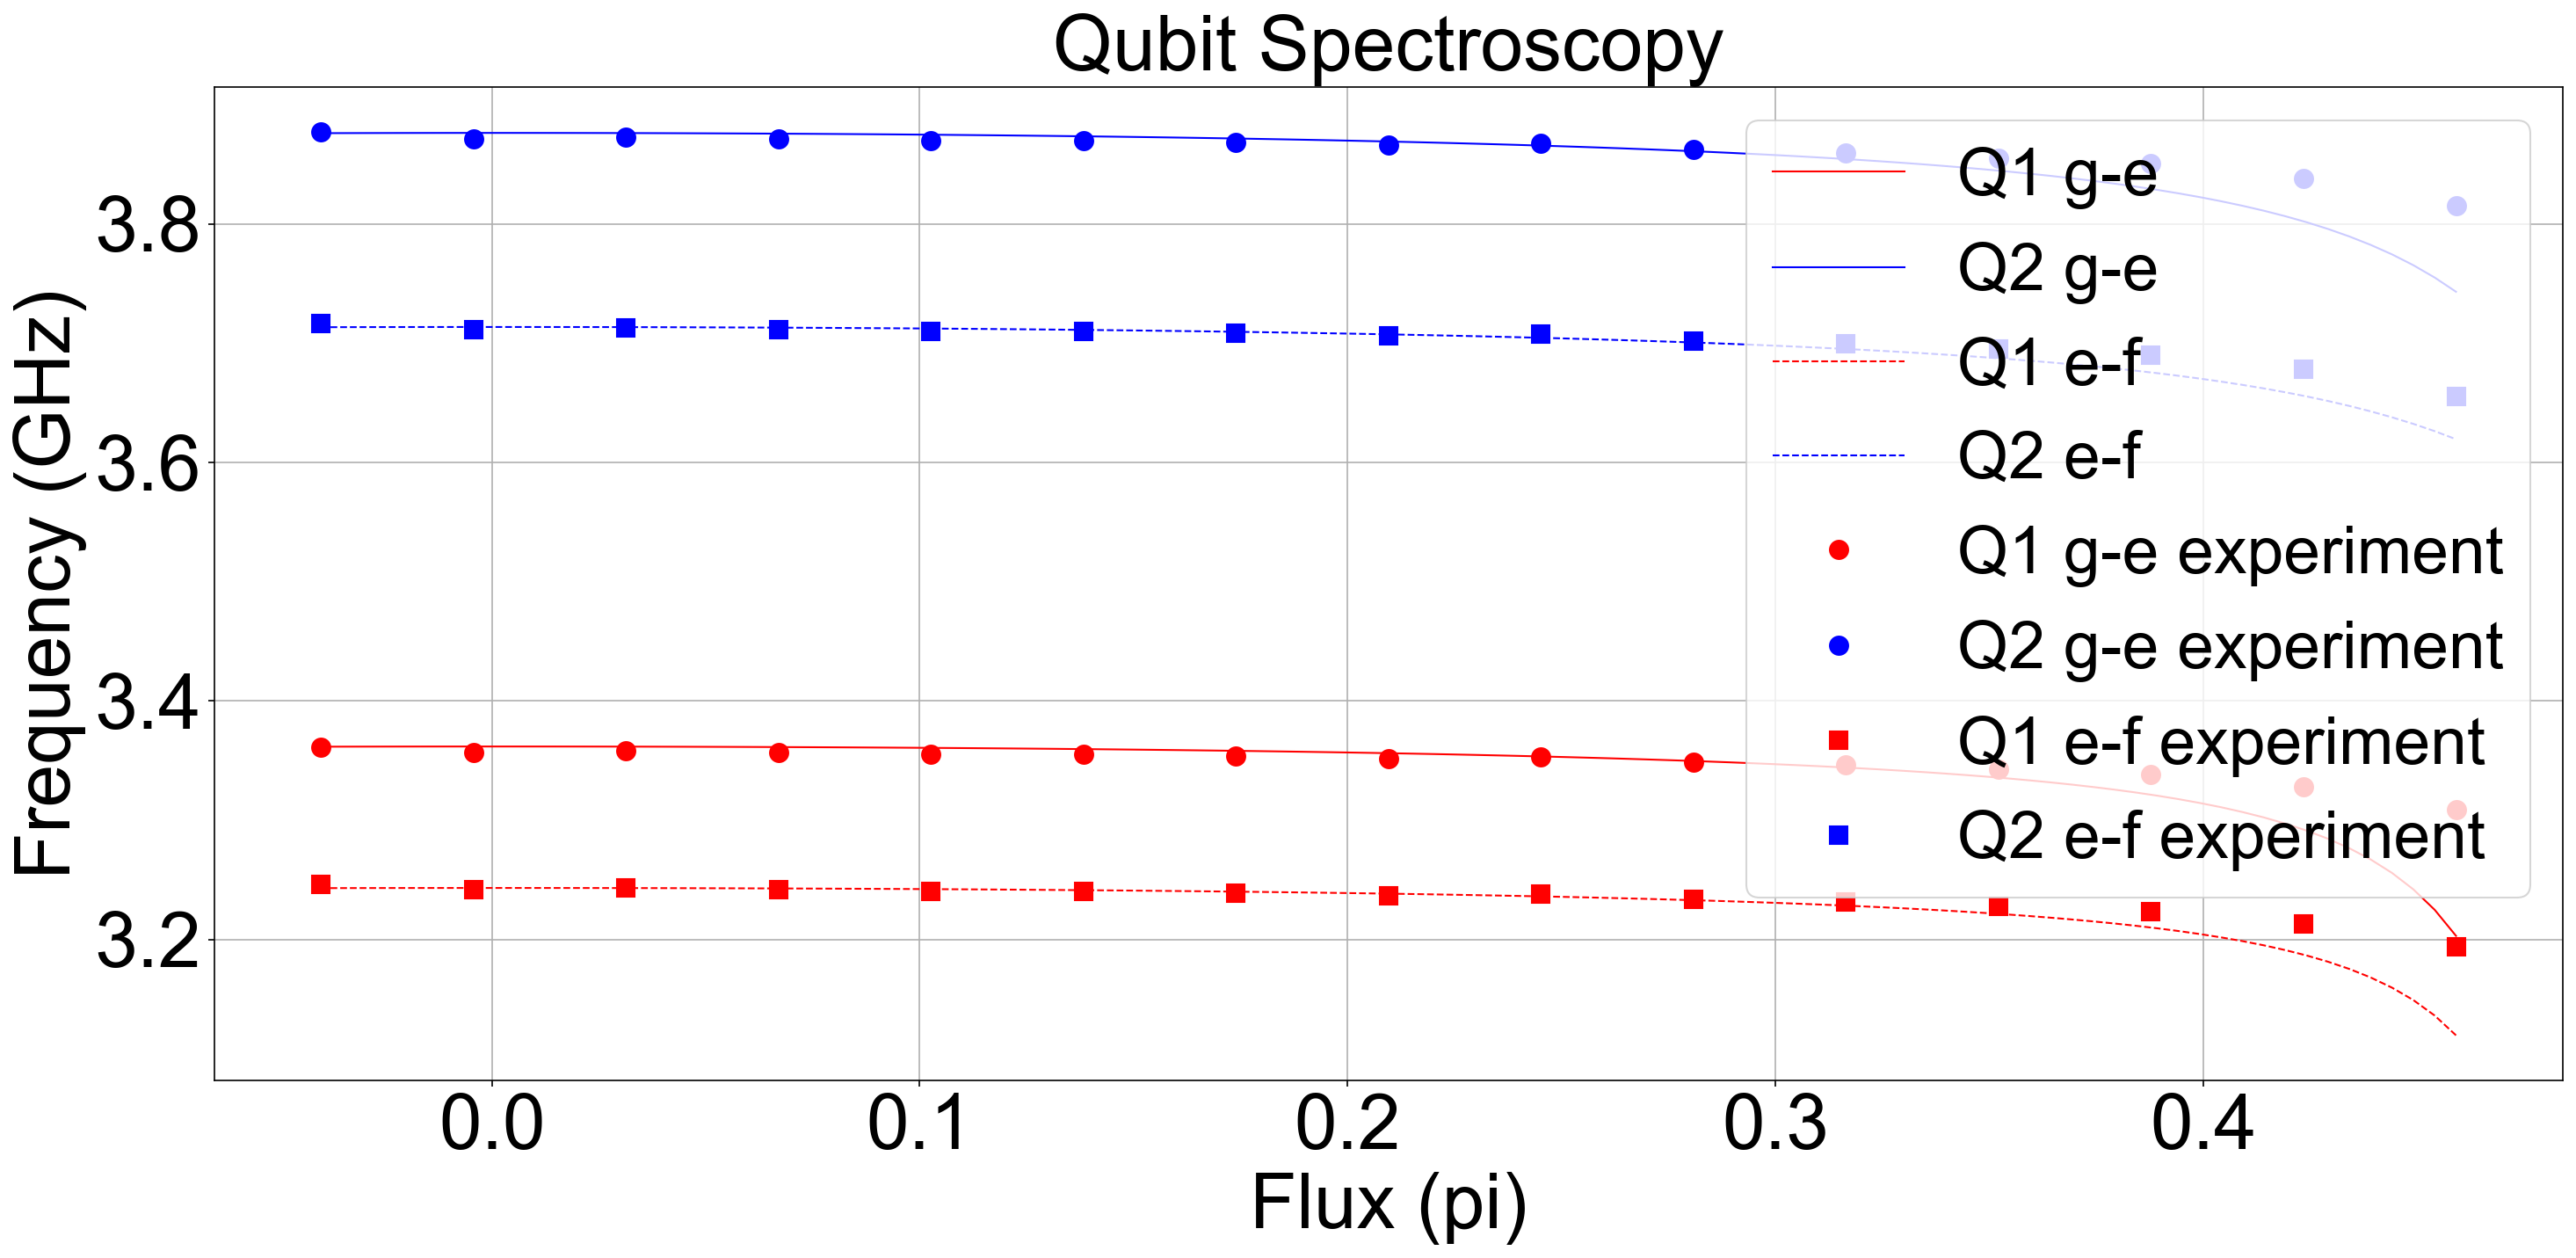

In [20]:
fig1 = plt.figure(figsize=(20,10))
plt.title("Qubit Spectroscopy", fontsize=42)
plt.plot(sweep_range/pi,fQ1, color='red', linewidth=1, linestyle='-', marker='o',markersize=0.,label=r'Q1 g-e')
plt.plot(sweep_range/pi,fQ2, color='blue', linewidth=1, linestyle='-', marker='o',markersize=0.,label=r'Q2 g-e')
plt.plot(sweep_range/pi,[sum(x) for x in zip(fQ1, Q1_a)], color='red', linewidth=1, linestyle='--', marker='o',markersize=0.,label=r'Q1 e-f')
plt.plot(sweep_range/pi,[sum(x) for x in zip(fQ2, Q2_a)], color='blue', linewidth=1, linestyle='--', marker='o',markersize=0.,label=r'Q2 e-f')

plt.plot(current_exp,Q1_exp, color='red', linewidth=0, linestyle='-', marker='o',markersize=10.,label=r'Q1 g-e experiment')
plt.plot(current_exp,Q2_exp, color='blue', linewidth=0, linestyle='-', marker='o',markersize=10.,label=r'Q2 g-e experiment')
plt.plot(current_exp,Q1ef_exp, color='red', linewidth=0, linestyle='-', marker='s',markersize=10.,label=r'Q1 e-f experiment')
plt.plot(current_exp,Q2ef_exp, color='blue', linewidth=0, linestyle='-', marker='s',markersize=10.,label=r'Q2 e-f experiment')

plt.tick_params(labelsize=42)
plt.rcParams['xtick.direction'] = 'in'  
plt.rcParams['ytick.direction'] = 'in'
# plt.title('3.0Cj', fontsize=36)
plt.xlabel('Flux (pi)', fontsize=42)
plt.ylabel('Frequency (GHz)', fontsize=42)
# plt.ylim(2.5,4)
plt.legend(fontsize=36)
# plt.axvline(0.36528,linestyle='--',color='black')
plt.grid()
plt.tight_layout()
# plt.savefig("specQ.pdf")
plt.show()


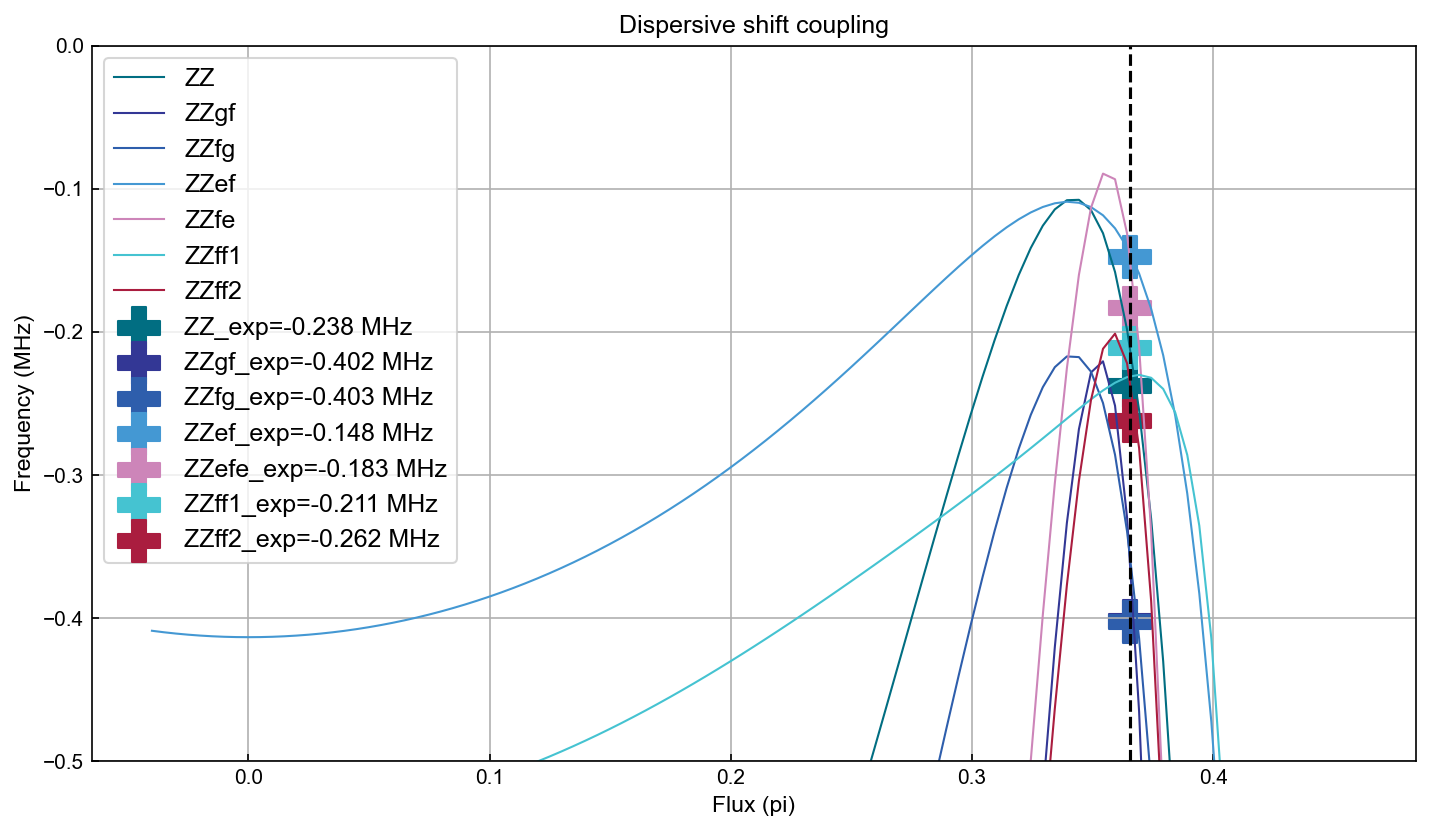

In [21]:
fig1 = plt.figure(figsize=(10,6))
plt.title("Dispersive shift coupling",fontsize=12)
plt.plot(sweep_range/pi,np.array(ZZ)*1000, linewidth=1, linestyle='-', marker='o',markersize=0.,label=r'ZZ')
plt.plot(sweep_range/pi,np.array(ZZgf)*1000, linewidth=1, linestyle='-', marker='o',markersize=0.,label=r'ZZgf')
plt.plot(sweep_range/pi,np.array(ZZfg)*1000, linewidth=1, linestyle='-', marker='o',markersize=0.,label=r'ZZfg')
plt.plot(sweep_range/pi,np.array(ZZef)*1000, linewidth=1, linestyle='-', marker='o',markersize=0.,label=r'ZZef')
plt.plot(sweep_range/pi,np.array(ZZfe)*1000, linewidth=1, linestyle='-', marker='o',markersize=0.,label=r'ZZfe')
plt.plot(sweep_range/pi,np.array(ZZff1)*1000, linewidth=1, linestyle='-', marker='o',markersize=0.,label=r'ZZff1')
plt.plot(sweep_range/pi,np.array(ZZff2)*1000, linewidth=1, linestyle='-', marker='o',markersize=0.,label=r'ZZff2')
# plt.plot(sweep_range/pi,ZZ1g, color='blue', linewidth=3, linestyle='-', marker='o',markersize=0.,label=r'ZZ 1-g')
# plt.plot(sweep_range/pi,ZZ2g, color='yellow', linewidth=3, linestyle='-', marker='o',markersize=0.,label=r'ZZ 2-g')
plt.scatter(0.36528, -0.238,marker='P',s=400, label=r'ZZ_exp=-0.238 MHz')
plt.scatter(0.36528, -0.402,marker='P',s=400, label=r'ZZgf_exp=-0.402 MHz')
plt.scatter(0.36528, -0.403,marker='P',s=400, label=r'ZZfg_exp=-0.403 MHz')
plt.scatter(0.36528, -0.148, marker='P',s=400, label=r'ZZef_exp=-0.148 MHz')
plt.scatter(0.36528, -0.183,marker='P',s=400, label=r'ZZefe_exp=-0.183 MHz')
plt.scatter(0.36528, -0.211,marker='P',s=400, label=r'ZZff1_exp=-0.211 MHz')
plt.scatter(0.36528, -0.262,marker='P',s=400, label=r'ZZff2_exp=-0.262 MHz')

plt.tick_params()
plt.rcParams['xtick.direction'] = 'in'  
plt.rcParams['ytick.direction'] = 'in'
# plt.title('3.0Cj', fontsize=36)
plt.xlabel('Flux (pi)')
plt.ylabel('Frequency (MHz)')
plt.ylim(-0.5,0)
plt.legend(fontsize=12)
plt.axvline(0.36528,linestyle='--',color='black')
plt.grid()
plt.tight_layout()
# plt.savefig("specZZ.pdf")
plt.show()

In [22]:
minzz([-0.000238,-0.000402,-0.000403,-0.000148,-0.000183,-0.000211,-0.000262])

matrix([[-304.31249993,   23.60416664,   37.77083331,    5.43750001]])

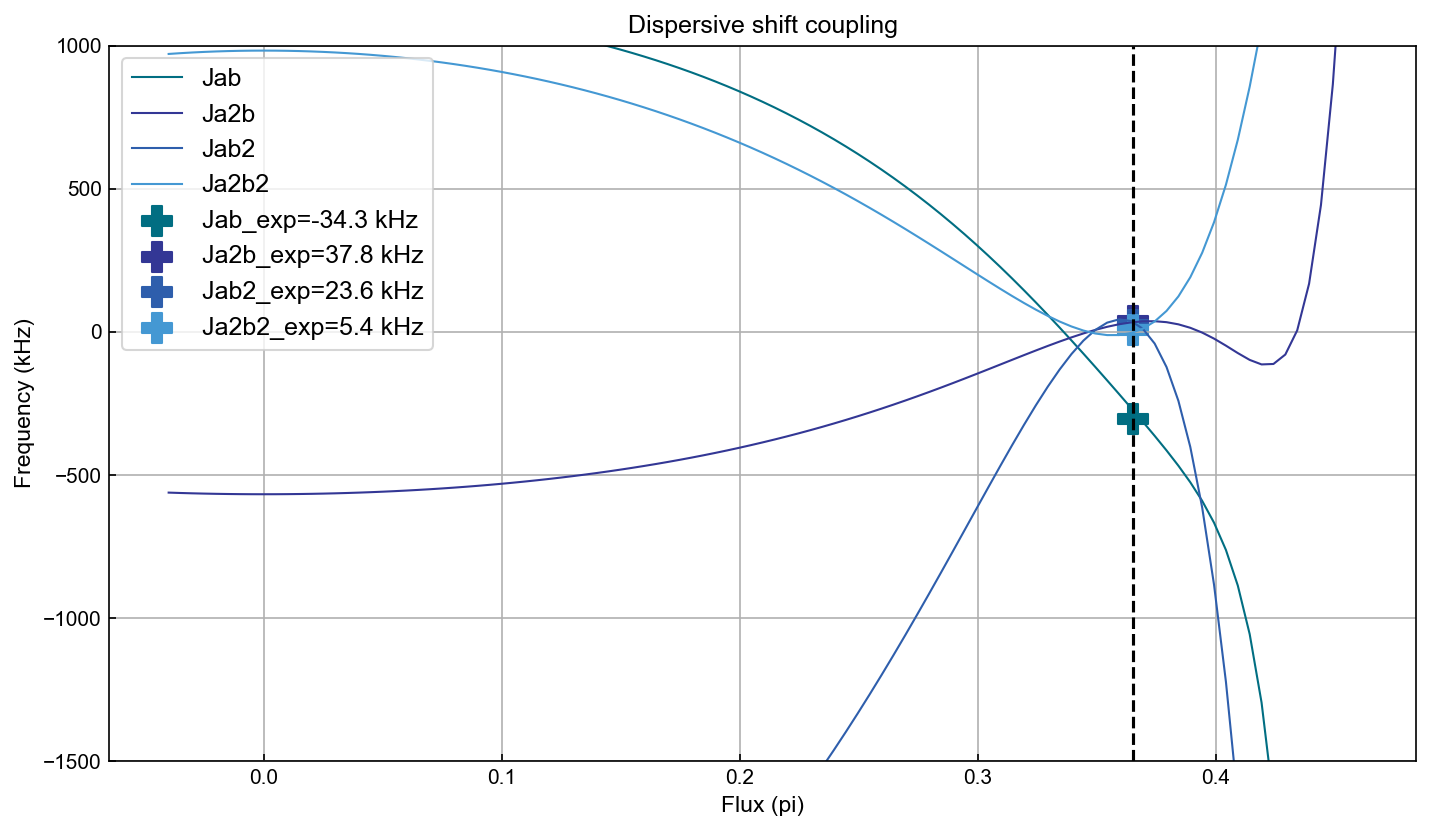

In [23]:
fig1 = plt.figure(figsize=(10,6))
plt.title("Dispersive shift coupling",fontsize=12)
plt.plot(sweep_range/pi,np.array(Jab), linewidth=1, linestyle='-', marker='o',markersize=0.,label=r'Jab')
plt.plot(sweep_range/pi,np.array(Ja2b), linewidth=1, linestyle='-', marker='o',markersize=0.,label=r'Ja2b')
plt.plot(sweep_range/pi,np.array(Jab2), linewidth=1, linestyle='-', marker='o',markersize=0.,label=r'Jab2')
plt.plot(sweep_range/pi,np.array(Ja2b2), linewidth=1, linestyle='-', marker='o',markersize=0.,label=r'Ja2b2')

plt.scatter(0.36528, -304.31249993,marker='P',s=200, label=r'Jab_exp=-34.3 kHz')
plt.scatter(0.36528, 37.77083331,marker='P',s=200, label=r'Ja2b_exp=37.8 kHz')
plt.scatter(0.36528, 23.60416664,marker='P',s=200, label=r'Jab2_exp=23.6 kHz')
plt.scatter(0.36528, 5.43750001, marker='P',s=200, label=r'Ja2b2_exp=5.4 kHz')


plt.tick_params()
plt.rcParams['xtick.direction'] = 'in'  
plt.rcParams['ytick.direction'] = 'in'
# plt.title('3.0Cj', fontsize=36)
plt.xlabel('Flux (pi)')
plt.ylabel('Frequency (kHz)')
plt.ylim(-1500,1000)
plt.legend(fontsize=12)
plt.axvline(0.36528,linestyle='--',color='black')
plt.grid()
plt.tight_layout()
# plt.savefig("specJJ.pdf")
plt.show()

## Frequency collision

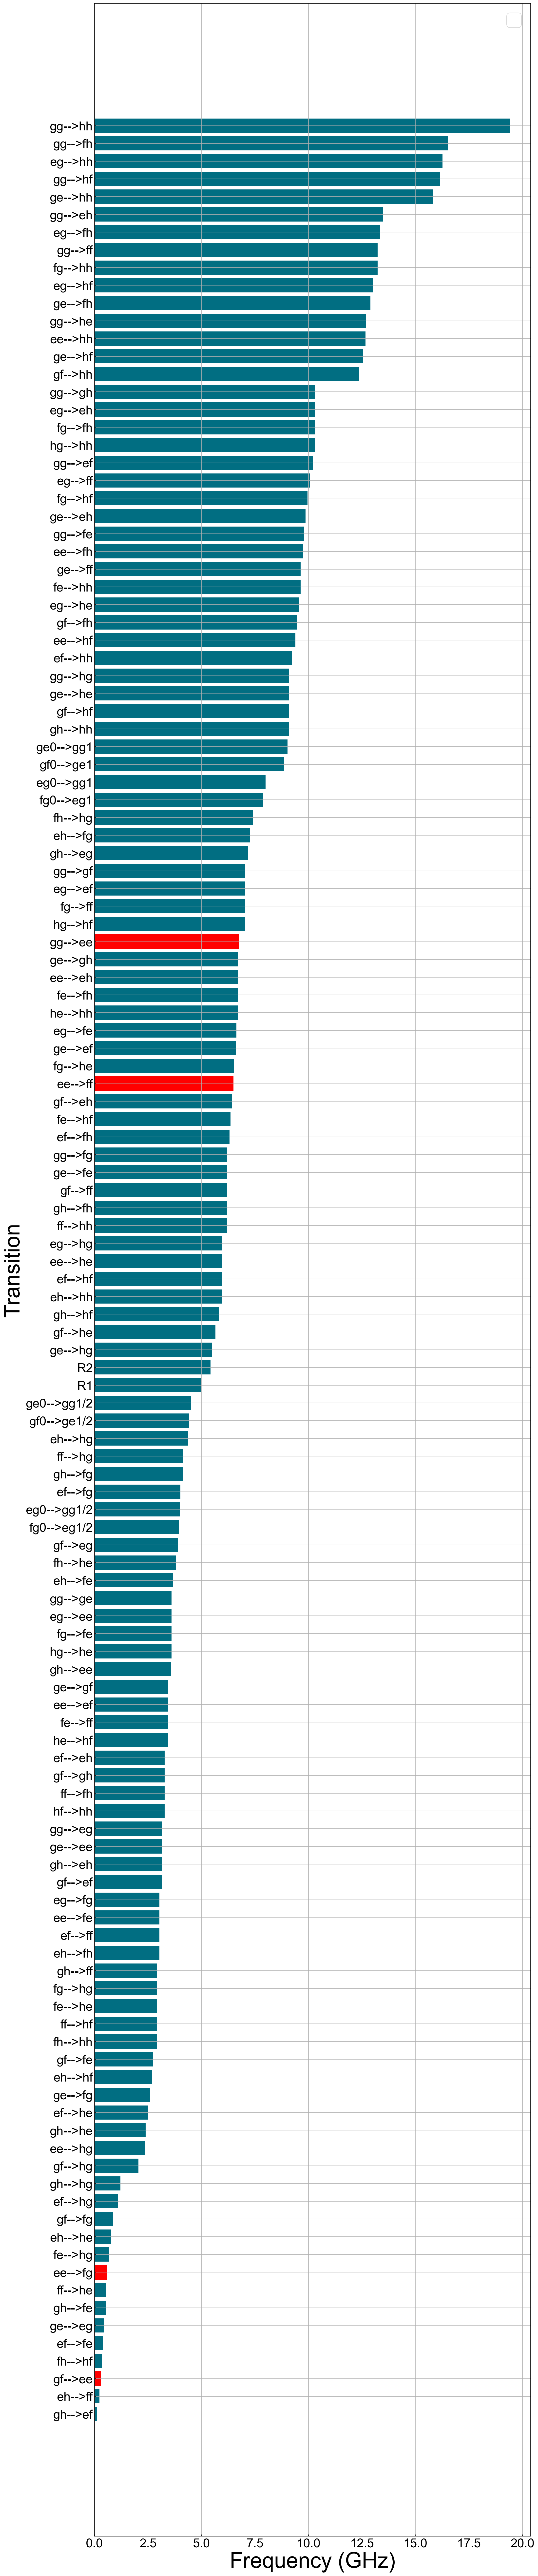

Target transition:  gg-->ee Frequency:  6.752619401930531
Closest frequency:  ge-->gh  Frequency:  6.713955257040084  and  hg-->hf  Frequency:  7.0445507035571495
Frequency difference(GHz):  0.038664144890447005  and  0.29193130162661873
#########################################
Target transition:  ee-->ff Frequency:  6.479167044915187
Closest frequency:  gf-->eh  Frequency:  6.421207931788672  and  fg-->he  Frequency:  6.514989667729765
Frequency difference(GHz):  0.057959113126514694  and  0.03582262281457815
#########################################
Target transition:  gf-->ee Frequency:  0.29263884610287505
Closest frequency:  eh-->ff  Frequency:  0.23467973297636036  and  fh-->hf  Frequency:  0.35685571920555503
Frequency difference(GHz):  0.057959113126514694  and  0.06421687310267998
#########################################
Target transition:  ee-->fg Frequency:  0.5655858828426972
Closest frequency:  ff-->he  Frequency:  0.529763260028119  and  fe-->hg  Frequency:  0.688218116

In [21]:
freq_list = np.array([0, 3.6019531646472274, 7.045258248033406, 10.315908421687311, 3.150845238524255, 6.752619401930531, 10.19580822789834, 13.466466179822078, 6.187033519087834, 9.788683144135746, 13.231786446845717, 16.501871450192027, 9.100465027429323, 12.702023186817598, 16.145015730986472, 19.415048914456463])
R1 = 4.9601
R2 = 5.4224
name_list = ['g', 'e', 'f', 'h']
collect = {}
for i in range(4):
    for j in range(4):
        for k in range(4):
            for l in range(4):
                if (4*i+j<4*k+l):
                    collect[name_list[i]+name_list[j]+'-->'+name_list[k]+name_list[l]]=abs(freq_list[4*i+j]-freq_list[4*k+l])
#                     collect[name_list[i]+name_list[j]+'-->'+name_list[k]+name_list[l]+'/2']=abs(freq_list[4*i+j]-freq_list[4*k+l])/2
collect['eg0-->gg1'] = R1+freq_list[8]-freq_list[4]
collect['fg0-->eg1'] = R1+freq_list[12]-freq_list[8]
collect['eg0-->gg1/2'] = (R1+freq_list[8]-freq_list[4])/2
collect['fg0-->eg1/2'] = (R1+freq_list[12]-freq_list[8])/2

collect['R1'] = R1
collect['R2'] = R2

collect['ge0-->gg1'] = R2+freq_list[1]-freq_list[0]
collect['gf0-->ge1'] = R2+freq_list[2]-freq_list[1]
collect['ge0-->gg1/2'] = (R2+freq_list[1]-freq_list[0])/2
collect['gf0-->ge1/2'] = (R2+freq_list[2]-freq_list[1])/2
Target_list = ['gg-->ee','ee-->ff','gf-->ee','ee-->fg']
Target_freq = []
for i in Target_list:
    Target_freq.append(collect[i])

sorted_freq = {}
sorted_freq = {k: v for k, v in sorted(collect.items(), key=lambda item: item[1])}
list1 = list(sorted_freq)

fig1 = plt.figure(figsize=(15,70))
ax1 = plt.barh(*zip(*sorted_freq.items()))
for i in Target_list:
    num = list1.index(i)
    ax1[num].set_color('r')

plt.tick_params(labelsize=24)
plt.rcParams['xtick.direction'] = 'in'  
plt.rcParams['ytick.direction'] = 'in'
# plt.title('Theoretical Fidelity', fontsize=36)
plt.ylabel('Transition', fontsize=42)
plt.xlabel('Frequency (GHz)', fontsize=42)
plt.legend(fontsize=36)
plt.grid()
plt.tight_layout()     
# plt.savefig('Frequency collision.pdf', dpi=300)
plt.show()

# plot frequency difference

for i in Target_list:    
    num = list1.index(i)
    middle = sorted_freq[i]
    minus = sorted_freq[list1[num-1]]
    plus = sorted_freq[list1[num+1]]
    print('Target transition: ',i, 'Frequency: ',middle)
    print('Closest frequency: ',list1[num-1],' Frequency: ', minus, ' and ',list1[num+1],' Frequency: ',plus)
    print('Frequency difference(GHz): ', middle-minus, ' and ', plus-middle)
    print('#########################################')
